# American Option Pricing with QuantLib and Python
[Gouthaman Balaraman](http://gouthamanbalaraman.com)

I wrote about pricing [European options using QuantLib](http://gouthamanbalaraman.com/blog/european-option-binomial-tree-quantlib-python.html) in an earlier post. Since then, I have received many questions from readers on how to extend this to price American options. So here is a modified example on pricing American options using QuantLib. The idea is very similar to European Option construction. Lets take a look at the details below. In this post, I will price both an European option and an American option side by side.

In [1]:
import QuantLib as ql 
import matplotlib.pyplot as plt
%matplotlib inline
ql.__version__

'1.9.2'

Let us consider a European and an American call option for AAPL with a strike price of \$130 maturing on 15th Jan, 2016. Let the spot price be \$127.62. The volatility of the underlying stock is known to be 20%, and has a dividend yield of 1.63%. Lets value these options as of 8th May, 2015.

In [2]:
# option data
maturity_date = ql.Date(15, 1, 2016)
spot_price = 127.62
strike_price = 130
volatility = 0.20 # the historical vols or implied vols
dividend_rate =  0.0163
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(8, 5, 2015)
ql.Settings.instance().evaluationDate = calculation_date

We construct the European and American options here. The main difference here is in the Exercise type. One has to use `AmericanExercise` instead of `EuropeanExercise` to pass into the `VanillaOption` to construct an American option.

In [3]:
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
settlement = calculation_date

am_exercise = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)

eu_exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, eu_exercise)

The Black-Scholes-Merton process is constructed here.

In [4]:
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)

The value of the American option can be computed using a Binomial Engine using the CRR approach.

In [5]:
steps = 200
binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
american_option.setPricingEngine(binomial_engine)
print (american_option.NPV())

6.84210328728556


For illustration purpose, lets compare the European and American option prices using the binomial tree approach. 

In [6]:
def binomial_price(option, bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    option.setPricingEngine(binomial_engine)
    return option.NPV()

steps = range(5, 200, 1)
eu_prices = [binomial_price(european_option, bsm_process, step) for step in steps]
am_prices = [binomial_price(american_option, bsm_process, step) for step in steps]
# theoretican European option price
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()

In the plot below, the binomial-tree approach is used to value American option for different number of steps. You can see the prices converging with increase in number of steps. The European option price is plotted along with BSM theoretical price for comparison purposes.

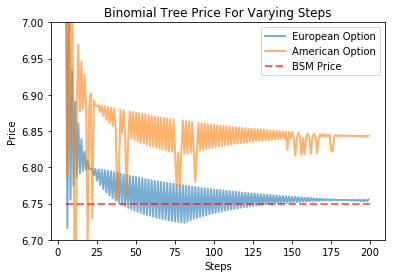

In [7]:
plt.plot(steps, eu_prices, label="European Option", lw=2, alpha=0.6)
plt.plot(steps, am_prices, label="American Option", lw=2, alpha=0.6)
plt.plot([5,200],[bs_price, bs_price], "r--", label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
plt.ylim(6.7,7)
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()